In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import optuna

/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('data/data_9.csv')
df.head(5)

,Result,FNL1,FNL2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,...,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2
0,0,2,3,68,73,32,24,5,3.0,41,...,10,17,25.0,36.0,173,3,7.0,6.0,6.0,6.0
1,0,2,3,53,46,47,35,7,7.0,47,...,7,19,30.0,43.0,152,6,3.0,4.0,6.0,6.0
2,1,3,2,57,62,43,43,13,0.0,50,...,3,7,28.0,44.0,152,1,7.0,6.0,6.0,6.0
3,0,2,3,64,63,36,23,7,4.0,49,...,6,12,28.0,37.0,131,6,7.0,4.0,0.0,6.0
4,0,2,3,60,58,40,21,13,8.0,40,...,5,9,31.0,46.0,153,1,4.0,6.0,6.0,6.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 39 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Result  17 non-null     int64  
 1   FNL1    17 non-null     int64  
 2   FNL2    17 non-null     int64  
 3   FSP.1   17 non-null     int64  
 4   FSW.1   17 non-null     int64  
 5   SSP.1   17 non-null     int64  
 6   SSW.1   17 non-null     int64  
 7   ACE.1   17 non-null     int64  
 8   DBF.1   17 non-null     float64
 9   WNR.1   17 non-null     int64  
 10  UFE.1   17 non-null     int64  
 11  BPC.1   17 non-null     int64  
 12  BPW.1   17 non-null     int64  
 13  NPA.1   17 non-null     float64
 14  NPW.1   17 non-null     float64
 15  TPW.1   17 non-null     int64  
 16  ST1.1   17 non-null     int64  
 17  ST2.1   17 non-null     float64
 18  ST3.1   17 non-null     float64
 19  ST4.1   17 non-null     float64
 20  ST5.1   17 non-null     float64
 21  FSP.2   17 non-null     int64  
 22  FSW.

In [6]:
# Check for missing values
list(filter(
    lambda x: x != 0,
    df.isna().sum()/df.shape[0]
))

[]

In [7]:
metadata = {
    'tgt': df.columns[0],
    'fts': df.columns[1:]  
}

In [8]:
df.nunique()

Result     2
FNL1       2
FNL2       2
FSP.1     13
FSW.1     15
SSP.1     13
SSW.1     13
ACE.1     11
DBF.1     10
WNR.1     16
UFE.1     16
BPC.1      8
BPW.1     12
NPA.1     13
NPW.1     12
TPW.1     15
ST1.1      5
ST2.1      4
ST3.1      6
ST4.1      7
ST5.1      9
FSP.2     11
FSW.2     15
SSP.2     11
SSW.2     14
ACE.2     13
DBF.2     11
WNR.2     16
UFE.2     15
BPC.2      7
BPW.2     11
NPA.2     15
NPW.2     15
TPW.2     14
ST1.2      5
ST2.2      6
ST3.2      5
ST4.2      7
ST5.2      6
dtype: int64

In [9]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=1.5):
        self.multiplier = multiplier
        self.lower_bound = None
        self.upper_bound = None

    def fit(self, X, y=None):
        # Calculate IQR for each feature
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        
        # Calculate lower and upper bounds for each feature
        self.lower_bound = Q1 - self.multiplier * IQR
        self.upper_bound = Q3 + self.multiplier * IQR
        
        return self
    
    def transform(self, X):
        # Check if bounds are calculated
        if self.lower_bound is None or self.upper_bound is None:
            raise ValueError("The fit method must be called before transform.")
        
        
        # Remove outliers
        mask = np.all((X >= self.lower_bound) & (X <= self.upper_bound), axis=1)
        return X[mask]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df[metadata['fts']], df[metadata['tgt']],
    test_size=0.2, random_state=42, stratify=df[metadata['tgt']]
)

In [11]:
full_pl = Pipeline(steps=[
    ('preprocessing', RobustScaler()),
    ('model', XGBClassifier(learning_rate=0.001, n_estimators=100, max_depth=3))
])

In [12]:
full_pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', RobustScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.001, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [13]:
scores = cross_val_score(
    estimator=full_pl,
    X=X_train, y=y_train,
    n_jobs=-1,
    cv= RepeatedStratifiedKFold(
        n_splits=4,
        n_repeats=3
    )
)

In [14]:
scores.mean(), scores.std()

(0.7083333333333334, 0.2975595178559521)

In [16]:
def objective(trial):
    
    param = dict(
        booster = trial.suggest_categorical('booster',['gbtree', 'gblinear', 'dart']),
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        n_estimators = trial.suggest_int('n_estimators', 100, 500),
        max_depth = trial.suggest_int('max_depth', 3, 10),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        gamma = trial.suggest_float('gamma', 0, 1),
        reg_lambda_ = trial.suggest_float('lambda', 1e-3, 1, log=True),
        reg_alpha = trial.suggest_float('alpha', 1e-3, 1, log=True),
        
    )
    
    pl = Pipeline(steps=[
        ('preprocessing', RobustScaler()),
        ('model', XGBClassifier(**param))
    ])
    
    scores = cross_val_score(
        estimator=pl,
        X=X_train, y=y_train, scoring=make_scorer(fbeta_score, beta=2),
        cv= RepeatedStratifiedKFold(
            n_splits=4,
            n_repeats=3
        ),
        n_jobs=-1
    )
    
    return scores.mean()


study = optuna.create_study(direction='maximize', study_name='XGBClassifier', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

[I 2024-05-27 11:34:29,219] A new study created in memory with name: XGBClassifier
/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:34:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "reg_lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:34:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "reg_lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:34:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight", "reg_lambda_" } are not

In [18]:
best_params = study.best_params

In [19]:
final_pl = Pipeline(steps=[
    ('preprocessing', RobustScaler()),
    ('model', XGBClassifier(**best_params))
])

final_scores = cross_val_score(
    estimator=final_pl,
    X=X_train, y=y_train, scoring=make_scorer(fbeta_score, beta=2),
    cv= RepeatedStratifiedKFold(
        n_repeats=3,
        n_splits=4
    )
)

/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:37:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:37:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:37:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packag

In [20]:
final_scores.mean(), final_scores.std()

(0.8720538720538721, 0.1689886880987152)

In [30]:
final_pl.fit(X_train, y_train)
final_preds = final_pl.predict(X_test)
print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



/Users/s223171213/Documents/machine-learning-docs/.mld-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)


<Axes: >

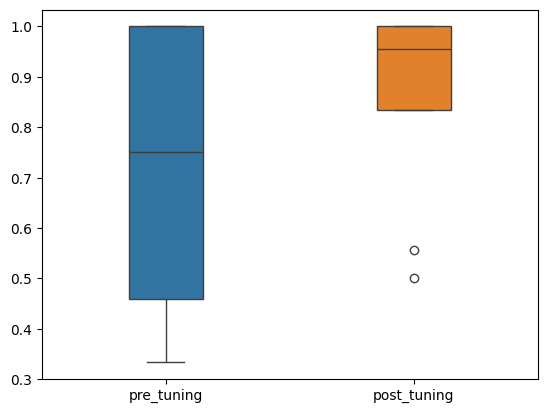

In [29]:
sns.boxplot(data=pd.DataFrame(
                                data= {
                                    'pre_tuning': scores,
                                    'post_tuning': final_scores
                                }
                            ), width=0.3)